## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')


import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

## Reading Data

In [4]:
df = pd.read_csv('/kaggle/input/news-sentiment-analysis/news.csv')[['news','sentiment']]

display(df.head())
print(df.shape)

,news,sentiment
0,It was a long antipodean night. While there’s ...,POSITIVE
1,In Mexico there are no licensing or registrati...,NEGATIVE
2,The government has until Monday to protect the...,POSITIVE
3,A record-breaking heat wave in the Southwest i...,POSITIVE
4,England started its Live Earth concert at Wemb...,NEGATIVE


(427482, 2)


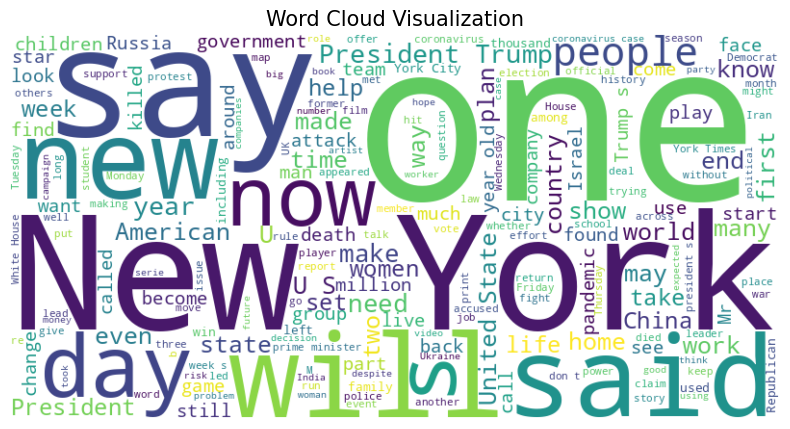

In [5]:
wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df.news))

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Visualization", fontsize=15)
plt.show()

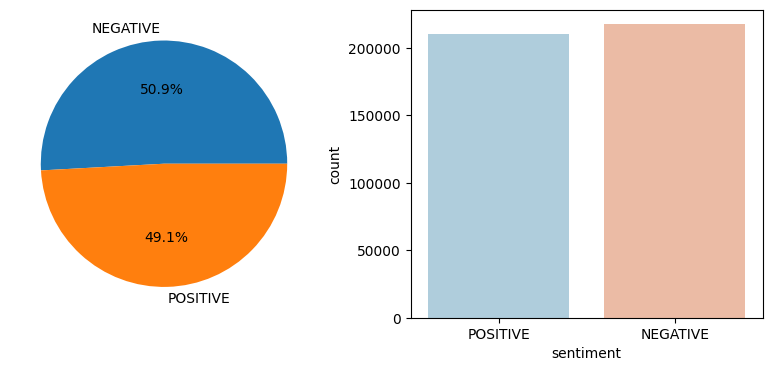

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].pie(df.sentiment.value_counts(), labels=df.sentiment.value_counts().index, autopct='%.1f%%')
sns.countplot(x='sentiment', data=df, palette='RdBu_r')
plt.show()

## Data Preprocessing

In [7]:
X_train_full, X_test, y_train_full, y_test = train_test_split(df['news'], df['sentiment'], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

In [37]:
def cleaning_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    text = re.sub(r'http\S+', '', text)  # Remove URLs

    tokens = word_tokenize(text)  # Tokenize

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]  # Lemmatize
    text = ' '.join(lemmatized_tokens)
    return text

In [9]:
X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)
X_valid = X_valid.apply(clean_text)

## ML Models

In [10]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [11]:
log_cla = LogisticRegression()
log_cla.fit(X_train_tfidf, y_train)

y_pred = log_cla.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8672000187141069
              precision    recall  f1-score   support

    NEGATIVE       0.88      0.86      0.87     43573
    POSITIVE       0.86      0.87      0.87     41924

    accuracy                           0.87     85497
   macro avg       0.87      0.87      0.87     85497
weighted avg       0.87      0.87      0.87     85497



In [12]:
from sklearn.naive_bayes import MultinomialNB

nb_cla = MultinomialNB()
nb_cla.fit(X_train_tfidf, y_train)

y_pred = nb_cla.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7868463220931728
              precision    recall  f1-score   support

    NEGATIVE       0.79      0.80      0.79     43573
    POSITIVE       0.79      0.78      0.78     41924

    accuracy                           0.79     85497
   macro avg       0.79      0.79      0.79     85497
weighted avg       0.79      0.79      0.79     85497



In [13]:
pa_cla = PassiveAggressiveClassifier()
pa_cla.fit(X_train_tfidf, y_train)

y_pred = pa_cla.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8511877609740692
              precision    recall  f1-score   support

    NEGATIVE       0.85      0.85      0.85     43573
    POSITIVE       0.85      0.85      0.85     41924

    accuracy                           0.85     85497
   macro avg       0.85      0.85      0.85     85497
weighted avg       0.85      0.85      0.85     85497



## LSTM Model

In [14]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

In [15]:
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)
valid_seq = tokenizer.texts_to_sequences(X_valid)

In [16]:
# vocab_size = len(tokenizer.word_index) + 1

In [17]:
# max_length = max(len(seq) for seq in train_seq)

In [18]:
train_pad = pad_sequences(train_seq,
                          maxlen=40,
                          truncating="post",
                          padding="post")
test_pad = pad_sequences(test_seq,
                         maxlen=40,
                         truncating="post",
                         padding="post")

valid_pad = pad_sequences(valid_seq,
                          maxlen=40,
                          truncating="post",
                          padding="post")

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [20]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(1000, 128))
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=128))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.0)
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

history = model.fit(train_pad, y_train,
              epochs=10,
              validation_data=(valid_pad, y_valid))

Epoch 1/10
9619/9619 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.6892 - loss: 0.5545 - val_accuracy: 0.7574 - val_loss: 0.4847
Epoch 2/10
9619/9619 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.7604 - loss: 0.4807 - val_accuracy: 0.7474 - val_loss: 0.4853
Epoch 3/10
9619/9619 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.7645 - loss: 0.4727 - val_accuracy: 0.7599 - val_loss: 0.4751
Epoch 4/10
9619/9619 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.7683 - loss: 0.4658 - val_accuracy: 0.7621 - val_loss: 0.4792
Epoch 5/10
9619/9619 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.7726 - loss: 0.4598 - val_accuracy: 0.7632 - val_loss: 0.4746
Epoch 6/10
9619/9619 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.7771 - loss: 0.4507 - val_accuracy: 0.7614 - val_loss: 0.4774
Epoch 7/10
9619/9619 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.7841 - loss: 0.4418 - val_accuracy: 0.7573 - val_loss: 0.4854
Epoch 8/10
9619/9619 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.7878 - loss: 0

In [22]:
model.evaluate(test_pad, y_test)

2672/2672 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7540 - loss: 0.5122


[0.5088080167770386, 0.7547282576560974]

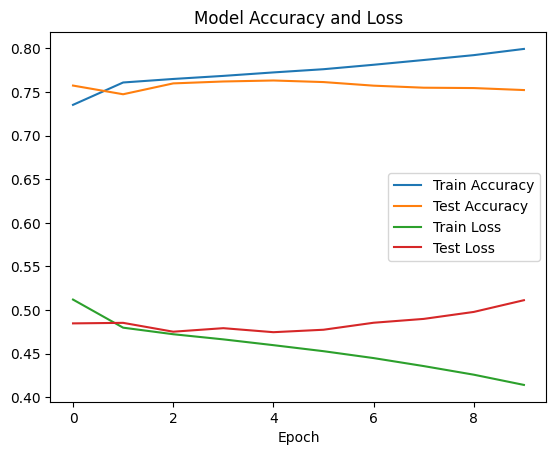

In [23]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')

plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
label_mapping = {index: label for index, label in enumerate(le.classes_)}
print(label_mapping)

{0: 'NEGATIVE', 1: 'POSITIVE'}


In [25]:
model.save("sentiment_model.h5")

In [26]:
import pickle

with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
with open("label_encoder.pkl", "wb") as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
text = 'from the river to the sea palestine will be free'
cleaned_text = cleaning_text(text)
print(cleaned_text)

river sea palestine free


In [41]:
seq = tokenizer.texts_to_sequences([cleaned_text])
print(seq)

[[675, 420]]


In [42]:
padded_seq = pad_sequences(seq, maxlen=40, truncating="post", padding="post")

prediction = model.predict(padded_seq)
sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
print(sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
positive
